### Assignment3

----- Non-Overlapping (2 classes) -----


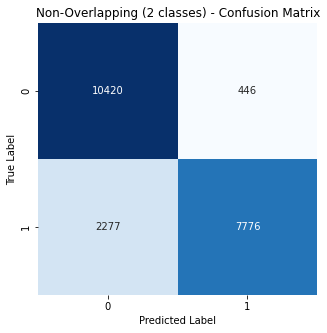

Non-Overlapping (2 classes) - Accuracy: 0.8698, F1-score: 0.8684

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     10866
           1       0.95      0.77      0.85     10053

    accuracy                           0.87     20919
   macro avg       0.88      0.87      0.87     20919
weighted avg       0.88      0.87      0.87     20919



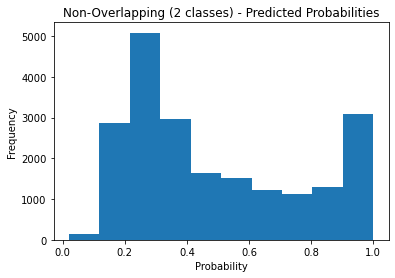

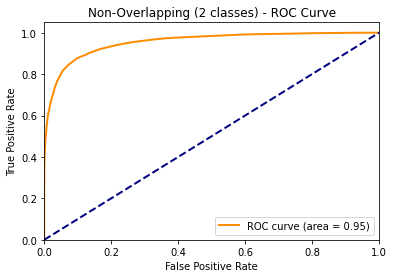

----- Sliding (2 classes) -----


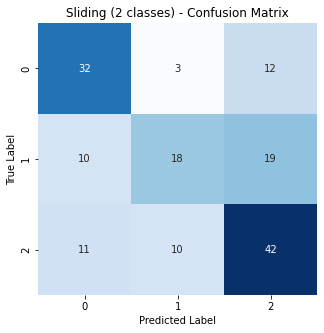

Sliding (2 classes) - Accuracy: 0.5860, F1-score: 0.5776

              precision    recall  f1-score   support

           0       0.60      0.68      0.64        47
           1       0.58      0.38      0.46        47
           2       0.58      0.67      0.62        63

    accuracy                           0.59       157
   macro avg       0.59      0.58      0.57       157
weighted avg       0.59      0.59      0.58       157

----- Non-Overlapping (3 classes) -----


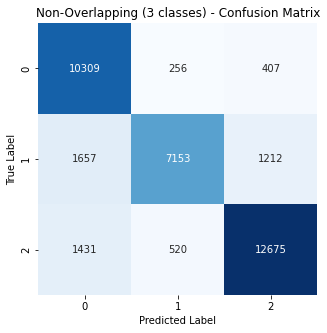

Non-Overlapping (3 classes) - Accuracy: 0.8461, F1-score: 0.8448

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     10972
           1       0.90      0.71      0.80     10022
           2       0.89      0.87      0.88     14626

    accuracy                           0.85     35620
   macro avg       0.85      0.84      0.84     35620
weighted avg       0.85      0.85      0.84     35620

----- Sliding (3 classes) -----


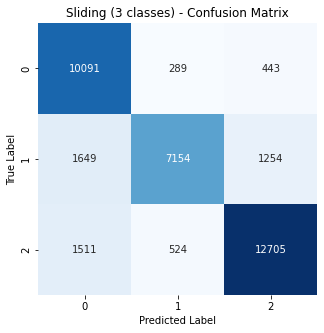

Sliding (3 classes) - Accuracy: 0.8408, F1-score: 0.8397

              precision    recall  f1-score   support

           0       0.76      0.93      0.84     10823
           1       0.90      0.71      0.79     10057
           2       0.88      0.86      0.87     14740

    accuracy                           0.84     35620
   macro avg       0.85      0.84      0.83     35620
weighted avg       0.85      0.84      0.84     35620



In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Loading the datasets ---
image_folder = r'C:\Users\Pradeep Nadella\Desktop\UNCG assignments\Semister 2\Big data and machine learning\Assignment 1'

df_non_overlapping_2 = pd.read_csv(f'{image_folder}\image01.csv')
df_sliding_2 = pd.read_csv(f'{image_folder}\herb_feature_vectors1.csv')
df_non_overlapping_3 = pd.read_csv(f'{image_folder}\image012.csv')
df_sliding_3 = pd.read_csv(f'{image_folder}\herb_sliding_block_feature_vectors1.csv')

# --- 2. Dividing the data domain into 80:20 (training:testing) ---
def split_data(df):
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

datasets = {
    'Non-Overlapping (2 classes)': split_data(df_non_overlapping_2),
    'Sliding (2 classes)': split_data(df_sliding_2),
    'Non-Overlapping (3 classes)': split_data(df_non_overlapping_3),
    'Sliding (3 classes)': split_data(df_sliding_3)
}

# --- 3. Applying PCA to the datasets ---
for dataset_name, (X_train, X_test, y_train, y_test) in datasets.items():
    # Standardizing the data before applying PCA
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Applying PCA with 95% variance retention
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Updating the datasets dictionary with the PCA-transformed data
    datasets[dataset_name] = (X_train_pca, X_test_pca, y_train, y_test)

# --- 4. Training and evaluating the Random Forest model on PCA-transformed data ---
# (because RF was the best suitable model for my dataset in assignent2)

def train_and_evaluate_rf(X_train, y_train, X_test, y_test, dataset_name):  # Modifying function signature
    """
    Trains and evaluates a Random Forest model with visualizations.
    """
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    # --- Adding predicted labels to the DataFrame and saving ---
    df_pred = pd.DataFrame({'predicted_label': y_pred}, index=y_test.index)
    
    # Converting X_test to DataFrame
    X_test_df = pd.DataFrame(X_test)
    
    # Ensuring y_test is a DataFrame
    if not isinstance(y_test, pd.DataFrame):
        y_test = pd.DataFrame(y_test)
        
    # Concatenating DataFrames
    df_combined = pd.concat([X_test_df, y_test, df_pred], axis=1)
    df_combined.to_csv(f'{dataset_name}_rf_pca_with_predictions.csv', index=False)

    # --- Constructing and visualizing confusion matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

    # --- Calculating performance measures ---
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'{dataset_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}\n')
    print(classification_report(y_test, y_pred))

    # --- Visualizing ---

    # Histogram of predicted probabilities (for 2-class datasets)
    if len(np.unique(y_train)) == 2:
        y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
        plt.figure()
        plt.hist(y_pred_prob, bins=10)
        plt.title(f'{dataset_name} - Predicted Probabilities')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')
        plt.show()

        # ROC curve (for 2-class datasets)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{dataset_name} - ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

# --- 5. Training and evaluating Random Forest for each dataset ---
for dataset_name, (X_train_pca, X_test_pca, y_train, y_test) in datasets.items():
    print(f'----- {dataset_name} -----')
    train_and_evaluate_rf(X_train_pca, y_train, X_test_pca, y_test, dataset_name)  # Pass X_test_pca instead of X_test